# ADA - ETE-3
    Name: Visesh Agarwal
    Reg No: 2347164

## Import Libraries

In [55]:
import asyncpraw
import nest_asyncio
import asyncio
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer


warnings.filterwarnings("ignore")
# Allow nested event loops
nest_asyncio.apply()

## Set up the reddit environment

In [56]:
reddit = asyncpraw.Reddit(
    client_id="",
    client_secret="",
    user_agent="",
    username="",
    password="",
)

## Scrape the comments data from the subreddit

In [57]:
async def get_comments(subreddit_name, num_comments=2000):
    subreddit = await reddit.subreddit(subreddit_name)
    comments = []
    async for comment in subreddit.comments(limit=num_comments):
        comments.append(
            {
                "subreddit": subreddit_name,
                "comment_body": comment.body,
                "upvotes": comment.score,
            }
        )
    return comments


async def main():
    subreddits = [
        "Python", 
        "DataScience",
        "MachineLearning",
        "DataAnalysis",
        "DataMining",
        "Data",
        "DataSets",
        "DataCenter"]
    
    all_comments = []

    for subreddit in subreddits:
        comments = await get_comments(
            subreddit, num_comments=5000
        )  # Adjust the number as needed
        all_comments.extend(comments)

    # Convert to DataFrame
    df = pd.DataFrame(all_comments)
    df.to_csv("reddit_comments_new.csv", index=False)
    print(f"Extracted {len(df)} comments.")

loop = asyncio.get_event_loop()
loop.run_until_complete(main())

Extracted 7444 comments.


## Data Cleaning and Data Information

In [58]:
# Load the extracted data
df = pd.read_csv('reddit_comments_new.csv')

# Step 1: Handle missing values
df.dropna(subset=['comment_body'], inplace=True)

# Step 2: Handle duplicates
df.drop_duplicates(subset=['comment_body'], inplace=True)
#   outliers  and  perform  necessary transformations.
# Step 3: Handle outliers
df = df[df['comment_body'].apply(lambda x: len(x.split()) > 2)]


print(df.head())

print(df['subreddit'].value_counts())

  subreddit                                       comment_body  upvotes
0    Python                  Do you set any internal API keys?        1
2    Python                                      Beat me to it        1
3    Python  No disrespect intended, but you're trying to r...        1
4    Python  Hi there, from the /r/Python mods.\n\nIt looks...        1
5    Python  * Scraping courses and tours from a website to...        1
subreddit
DataCenter         934
Python             859
DataMining         847
Data               803
DataScience        763
DataSets           763
MachineLearning    733
DataAnalysis       645
Name: count, dtype: int64


# Data Preprocessing

In [59]:
# Step 3: Clean the text data
def clean_text(text):
    # tokenize the text
    text = word_tokenize(text)
    # remove special characters
    text = [re.sub(r"[^a-zA-Z0-9]+", ' ', word) for word in text]
    # remove words with digits
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # convert to lower case
    text = [word.lower() for word in text]
    # remove stopwords
    text = [word for word in text if word not in stopwords.words('english')]
    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    # join the words
    text = ' '.join(text)
    # remove some special characters
    text = re.sub(r'[^\w\s]', '', text)
    # remove specific words
    words = ['http','com','www','reddit','comment','comments','http','https','org','jpg','png','gif','jpeg','html','pdf','youtu','youtube','watch','v','amp']
    text = ' '.join(word for word in text.split() if word not in words)
    return text


# Apply the cleaning function to the 'comment_body' column
df["cleaned_comment"] = df["comment_body"].apply(clean_text)

df.head()

,subreddit,comment_body,upvotes,cleaned_comment
0,Python,Do you set any internal API keys?,1,set internal api key
2,Python,Beat me to it,1,beat
3,Python,"No disrespect intended, but you're trying to r...",1,disrespect intended re trying reinvent wheel r...
4,Python,"Hi there, from the /r/Python mods.\n\nIt looks...",1,hi r python mod look like asking help suggest ...
5,Python,* Scraping courses and tours from a website to...,1,scraping course tour website make r feed makin...


## Display the count of comments for each subreddits

In [60]:
print(df['subreddit'].value_counts())

subreddit
DataCenter         934
Python             859
DataMining         847
Data               803
DataScience        763
DataSets           763
MachineLearning    733
DataAnalysis       645
Name: count, dtype: int64


## Display WordCloud

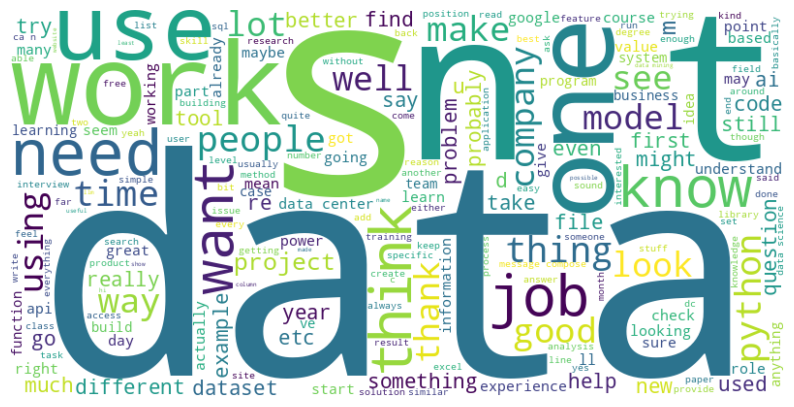

In [61]:
# Combine all comments into a single string
text = " ".join(comment for comment in df.cleaned_comment)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 1. Sentiment Analysis using TextBlob

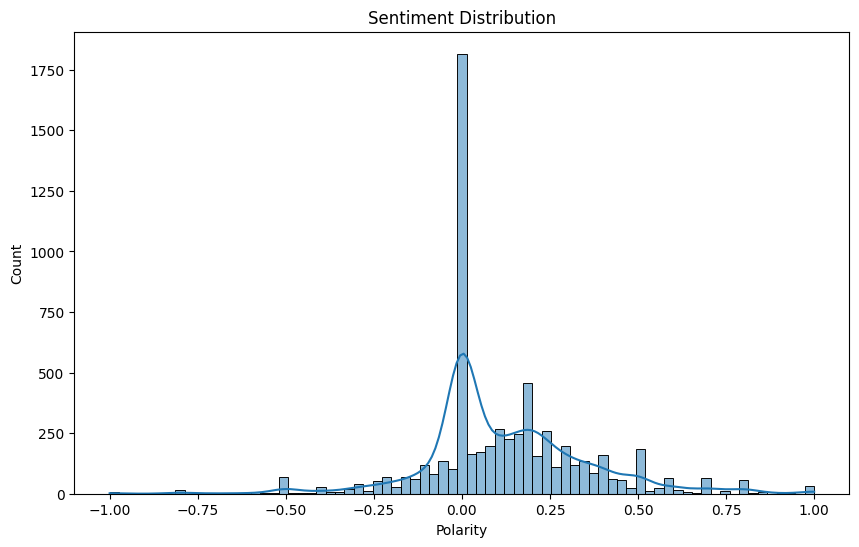

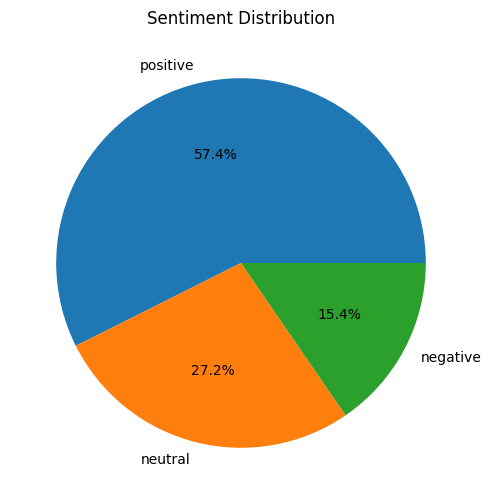

In [62]:
# Sentiment Analysis
from textblob import TextBlob

# Calculate the sentiment of each comment
df['polarity'] = df['cleaned_comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

# categorize the sentiment
df['sentiment'] = df['polarity'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

# Display the sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['polarity'], kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

# pie chart
plt.figure(figsize=(10, 6))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()


## 2. Topic Modelling using LDA

In [63]:
stop_words = set(stopwords.words("english"))

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens


# Apply preprocessing to the cleaned comments
df["tokens"] = df["cleaned_comment"].apply(preprocess)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

# Set parameters for LDA
num_topics = 5  # You can adjust the number of topics
passes = 15  # Number of passes through the corpus during training

# Train the LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus, num_topics=num_topics, id2word=dictionary, passes=passes
)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim

# Assuming your LDA model and other variables are already defined
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)


(0, '0.032*"post" + 0.021*"please" + 0.021*"r" + 0.018*"message" + 0.015*"thank"')
(1, '0.014*"cooling" + 0.010*"power" + 0.010*"rack" + 0.007*"ups" + 0.007*"system"')
(2, '0.016*"data" + 0.011*"n" + 0.010*"like" + 0.010*"would" + 0.010*"get"')
(3, '0.018*"data" + 0.011*"n" + 0.011*"use" + 0.009*"would" + 0.009*"need"')
(4, '0.015*"data" + 0.014*"power" + 0.013*"center" + 0.009*"get" + 0.007*"like"')


/home/visesh/miniconda3/lib/python3.12/site-packages/pytz/tzinfo.py:27: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _epoch = datetime.utcfromtimestamp(0)
/home/visesh/miniconda3/lib/python3.12/site-packages/pytz/tzinfo.py:27: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _epoch = datetime.utcfromtimestamp(0)
/home/visesh/miniconda3/lib/python3.12/site-packages/pytz/tzinfo.py:27: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  

## 3. Subreddit-Specific Analysis

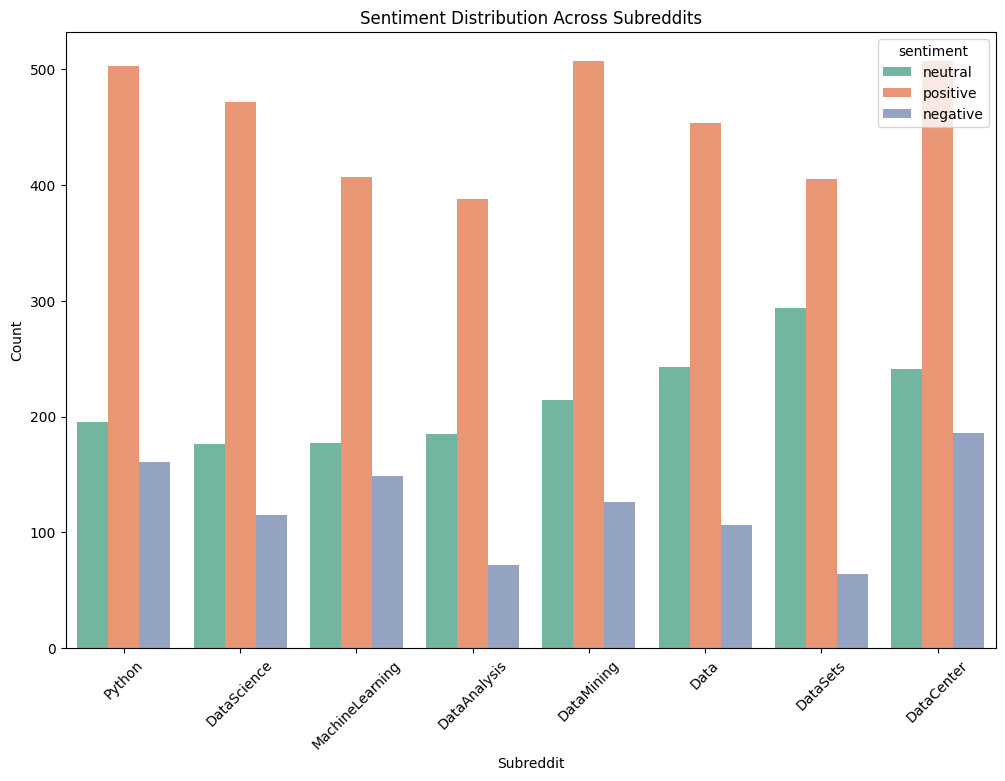

In [64]:
# Display sentiment distribution across subreddits
plt.figure(figsize=(12, 8))
sns.countplot(x="subreddit", hue="sentiment", data=df, palette="Set2")
plt.title("Sentiment Distribution Across Subreddits")
plt.xlabel("Subreddit")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## 4. Emotion Analysis

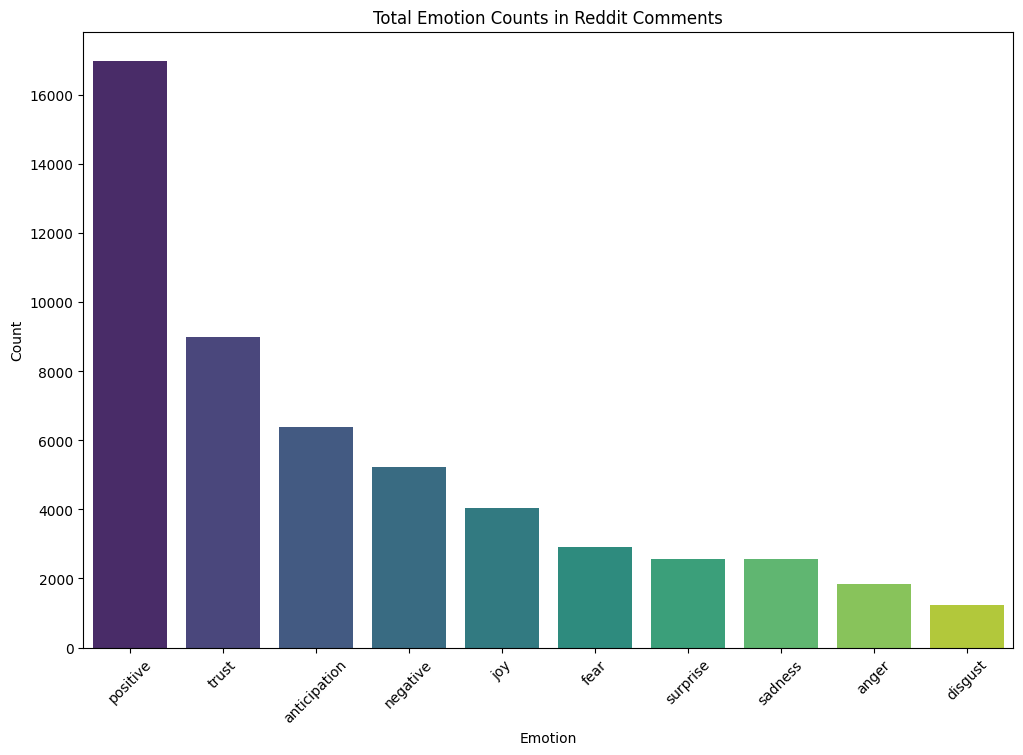

<Figure size 1200x800 with 0 Axes>

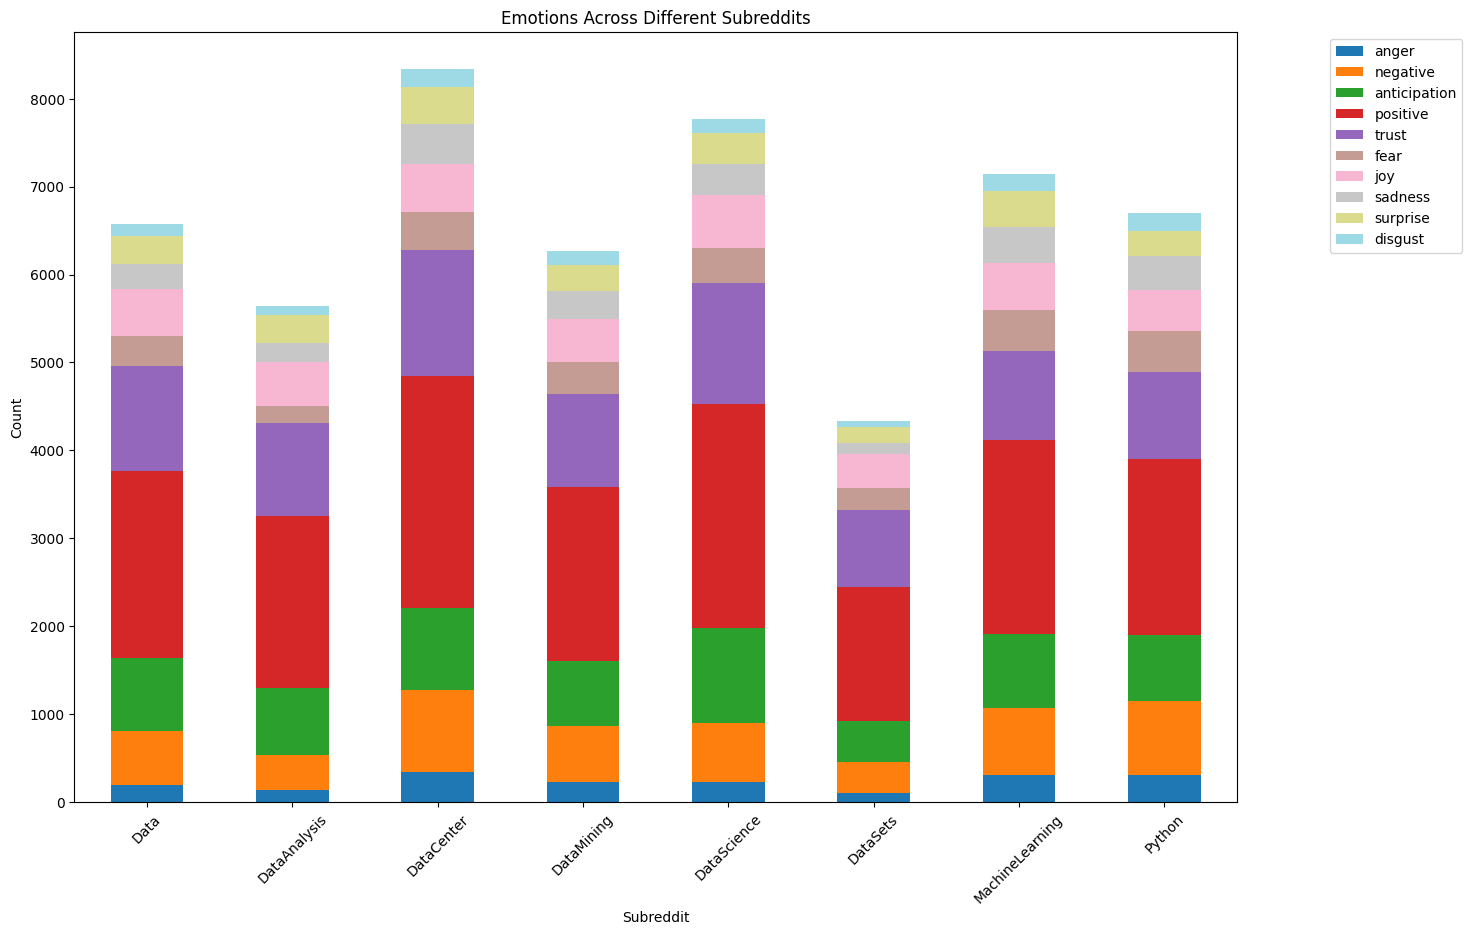

In [65]:
from nrclex import NRCLex

# Function to perform emotion analysis
def analyze_emotions(text):
    emotion = NRCLex(text)
    return emotion.raw_emotion_scores


# Apply the emotion analysis to each cleaned comment
df["emotions"] = df["cleaned_comment"].apply(analyze_emotions)

# Convert the dictionary of emotions into individual columns
emotion_df = df["emotions"].apply(pd.Series).fillna(0)

# Add the emotion columns back to the original dataframe
df = pd.concat([df, emotion_df], axis=1)

# Display the sum of each emotion across the entire dataset
emotion_totals = emotion_df.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=emotion_totals.index, y=emotion_totals.values, palette="viridis")
plt.title("Total Emotion Counts in Reddit Comments")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# If you want to visualize emotions across different subreddits:
plt.figure(figsize=(12, 8))
emotion_sums_by_subreddit = emotion_df.groupby(df["subreddit"]).sum()
emotion_sums_by_subreddit.plot(
    kind="bar", stacked=True, figsize=(15, 10), colormap="tab20"
)
plt.title("Emotions Across Different Subreddits")
plt.xlabel("Subreddit")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

# 5. Named Entity Recognition

                                     cleaned_comment entities
0                               set internal api key       []
2                                               beat       []
3  disrespect intended re trying reinvent wheel r...       []
4  hi r python mod look like asking help suggest ...       []
5  scraping course tour website make r feed makin...       []


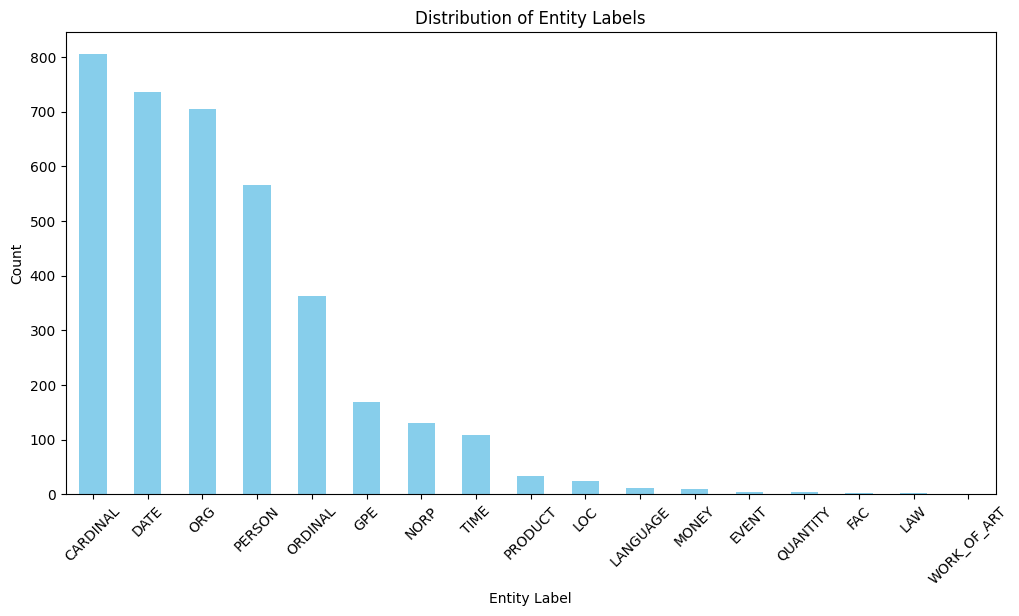

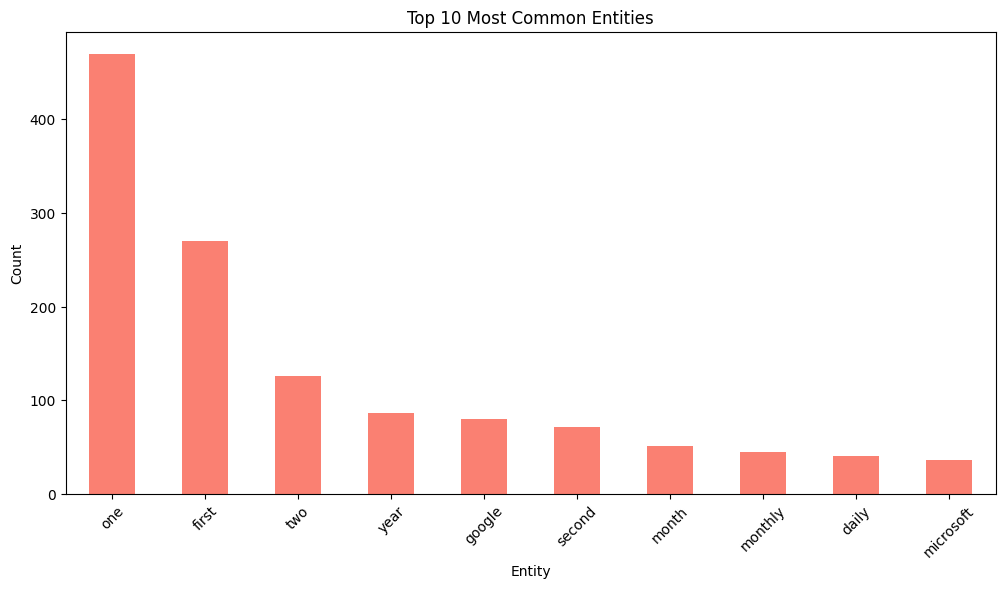

In [66]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")


# Function to perform NER and extract entities
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities


# Apply the NER function to each comment
df["entities"] = df["cleaned_comment"].apply(extract_entities)

# Display the first few rows to see the extracted entities
print(df[["cleaned_comment", "entities"]].head())

# Flatten the list of entities to analyze them
all_entities = [entity for sublist in df["entities"] for entity in sublist]

# Create a DataFrame of entities and their labels
entities_df = pd.DataFrame(all_entities, columns=["Entity", "Label"])

# Count the frequency of each entity label
label_counts = entities_df["Label"].value_counts()

# Plot the distribution of entity labels
plt.figure(figsize=(12, 6))
label_counts.plot(kind="bar", color="skyblue")
plt.title("Distribution of Entity Labels")
plt.xlabel("Entity Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# If you want to see the most common entities
top_entities = entities_df["Entity"].value_counts().head(10)

# Plot the most common entities
plt.figure(figsize=(12, 6))
top_entities.plot(kind="bar", color="salmon")
plt.title("Top 10 Most Common Entities")
plt.xlabel("Entity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# 1. SVM Classifier

In [67]:
# SVM
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Encode the target variable
label_encoder = LabelEncoder()
df["subreddit_label"] = label_encoder.fit_transform(df["subreddit"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df["cleaned_comment"], df["subreddit_label"], test_size=0.2, random_state=42
)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train the SVM model
svm_model = SVC(kernel="linear", probability=True)  # Enable probability estimates
svm_model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

# Calculate ROC AUC Score
if hasattr(svm_model, "predict_proba"):
    y_prob = svm_model.predict_proba(X_test_vectorized)
    roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
else:
    roc_auc = None

print(f"SVM Model Accuracy: {accuracy}")
print(f"SVM Model Precision: {precision}")
print(f"SVM Model Recall: {recall}")
print(f"SVM Model F1 Score: {f1}")
print(f"SVM Model ROC AUC Score: {roc_auc}")

SVM Model Accuracy: 0.5236220472440944
SVM Model Precision: 0.5334834104292766
SVM Model Recall: 0.5236220472440944
SVM Model F1 Score: 0.5257469696915541
SVM Model ROC AUC Score: 0.8535771718938111


# 2. Logistic Regression Classifier

In [68]:
# logistic regression

# Encode the target variable
label_encoder = LabelEncoder()
df["subreddit_label"] = label_encoder.fit_transform(df["subreddit"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df["cleaned_comment"], df["subreddit_label"], test_size=0.2, random_state=42
)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_vectorized)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average="weighted")
recall_lr = recall_score(y_test, y_pred_lr, average="weighted")
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")

# Calculate ROC AUC Score using predict_proba
if hasattr(lr_model, "predict_proba"):
    y_prob_lr = lr_model.predict_proba(X_test_vectorized)
    roc_auc_lr = roc_auc_score(y_test, y_prob_lr, multi_class="ovr", average="weighted")
else:
    roc_auc_lr = None

print(f"Logistic Regression Model Accuracy: {accuracy_lr}")
print(f"Logistic Regression Model Precision: {precision_lr}")
print(f"Logistic Regression Model Recall: {recall_lr}")
print(f"Logistic Regression Model F1 Score: {f1_lr}")
print(f"Logistic Regression Model ROC AUC Score: {roc_auc_lr}")

Logistic Regression Model Accuracy: 0.5417322834645669
Logistic Regression Model Precision: 0.5451372094171405
Logistic Regression Model Recall: 0.5417322834645669
Logistic Regression Model F1 Score: 0.5361759238916388
Logistic Regression Model ROC AUC Score: 0.8576761060692843


## 3. Random Forest Classifier

In [69]:
# random forest
# Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_vectorized)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average="weighted")
recall_rf = recall_score(y_test, y_pred_rf, average="weighted")
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")

# Calculate ROC AUC Score using predict_proba
if hasattr(rf_model, "predict_proba"):
    y_prob_rf = rf_model.predict_proba(X_test_vectorized)
    roc_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class="ovr", average="weighted")
else:
    roc_auc_rf = None


print(f"Random Forest Model Accuracy: {accuracy_rf}")
print(f"Random Forest Model Precision: {precision_rf}")
print(f"Random Forest Model Recall: {recall_rf}")
print(f"Random Forest Model F1 Score: {f1_rf}")
print(f"Random Forest Model ROC AUC Score: {roc_auc_rf}")

Random Forest Model Accuracy: 0.48503937007874015
Random Forest Model Precision: 0.4884237407707543
Random Forest Model Recall: 0.48503937007874015
Random Forest Model F1 Score: 0.4778307445701116
Random Forest Model ROC AUC Score: 0.8191243941901507


## 4. LSTM Model

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.1536 - loss: 2.0680 - val_accuracy: 0.3081 - val_loss: 1.9128
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.3182 - loss: 1.8124 - val_accuracy: 0.3573 - val_loss: 1.6621
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.4873 - loss: 1.3854 - val_accuracy: 0.4568 - val_loss: 1.5337
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.6590 - loss: 1.0377 - val_accuracy: 0.4795 - val_loss: 1.5056
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7753 - loss: 0.7152 - val_accuracy: 0.4833 - val_loss: 1.5790
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 314ms/step - accuracy: 0.4742 - loss: 1.5975
LSTM Model Accuracy: 0.4833018183708191


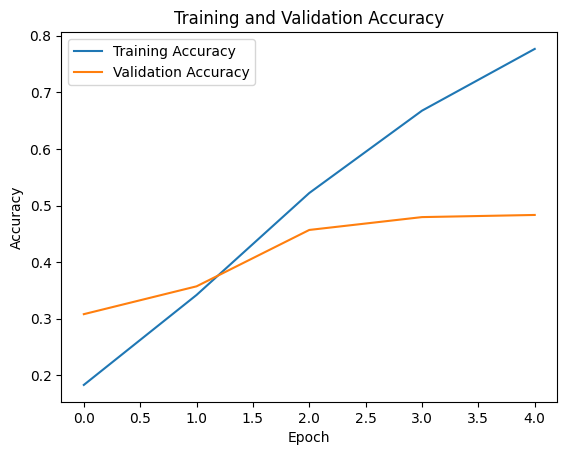

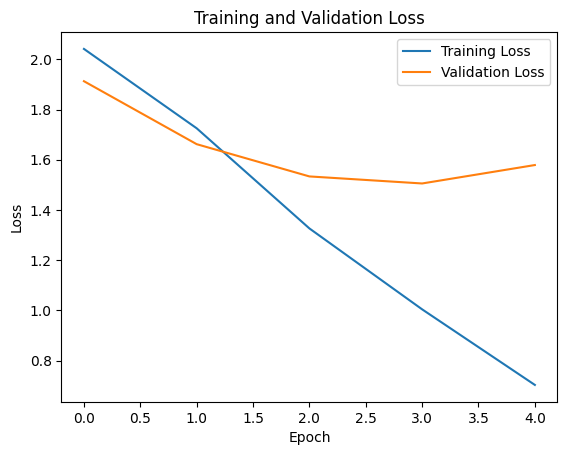

In [70]:
# LSTM
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["cleaned_comment"])
X = tokenizer.texts_to_sequences(df["cleaned_comment"])
X = pad_sequences(X)

# Split the data into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X, df["subreddit_label"], test_size=0.2, random_state=42
)

# Create the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(len(tokenizer.word_index) + 1, 128))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(8, activation="softmax"))

lstm_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the LSTM model
history = lstm_model.fit(
    X_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_data=(X_test_lstm, y_test_lstm)
)

# Evaluate the LSTM model
loss, accuracy_lstm = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print(f"LSTM Model Accuracy: {accuracy_lstm}")

# Plot the training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [71]:
# Score the LSTM model
import numpy as np

def score_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(pred) for pred in y_pred]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    # Calculate ROC AUC Score using predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
    else:
        roc_auc = None
    return accuracy, precision, recall, f1, roc_auc


# Score the LSTM model
accuracy_lstm, precision_lstm, recall_lstm, f1_lstm, roc_auc_lstm = score_model(
    lstm_model, X_test_lstm, y_test_lstm
)

print(f"LSTM Model Accuracy: {accuracy_lstm}")
print(f"LSTM Model Precision: {precision_lstm}")
print(f"LSTM Model Recall: {recall_lstm}")
print(f"LSTM Model F1 Score: {f1_lstm}")
print(f"LSTM Model ROC AUC Score: {roc_auc_lstm}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step
LSTM Model Accuracy: 0.48330182734719596
LSTM Model Precision: 0.4831033085454357
LSTM Model Recall: 0.48330182734719596
LSTM Model F1 Score: 0.47826518387389827
LSTM Model ROC AUC Score: None


## 5. KNN Classifier

In [74]:
# knn
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test_vectorized)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average="weighted")
recall_knn = recall_score(y_test, y_pred_knn, average="weighted")
f1_knn = f1_score(y_test, y_pred_knn, average="weighted")
# Calculate ROC AUC Score using predict_proba
if hasattr(knn_model, "predict_proba"):
    y_prob_knn = knn_model.predict_proba(X_test_vectorized)
    roc_auc_knn = roc_auc_score(y_test, y_prob_knn, multi_class="ovr", average="weighted")
else:
    roc_auc_knn = None

print(f"KNN Model Accuracy: {accuracy_knn}")
print(f"KNN Model Precision: {precision_knn}")
print(f"KNN Model Recall: {recall_knn}")
print(f"KNN Model F1 Score: {f1_knn}")
print(f"KNN Model ROC AUC Score: {roc_auc_knn}")

KNN Model Accuracy: 0.23070866141732282
KNN Model Precision: 0.32654453546842
KNN Model Recall: 0.23070866141732282
KNN Model F1 Score: 0.15102816632882568
KNN Model ROC AUC Score: 0.7203185418876082


## Comparison of all the models

                 Model  Accuracy  Precision    Recall  F1 Score   Rou_AUC
0                  SVM  0.523622   0.533483  0.523622  0.525747  0.853577
1  Logistic Regression  0.541732   0.545137  0.541732  0.536176  0.857676
2        Random Forest  0.485039   0.488424  0.485039  0.477831  0.819124
3                  KNN  0.230709   0.326545  0.230709  0.151028  0.720319
4                 LSTM  0.483302   0.483103  0.483302  0.478265       NaN


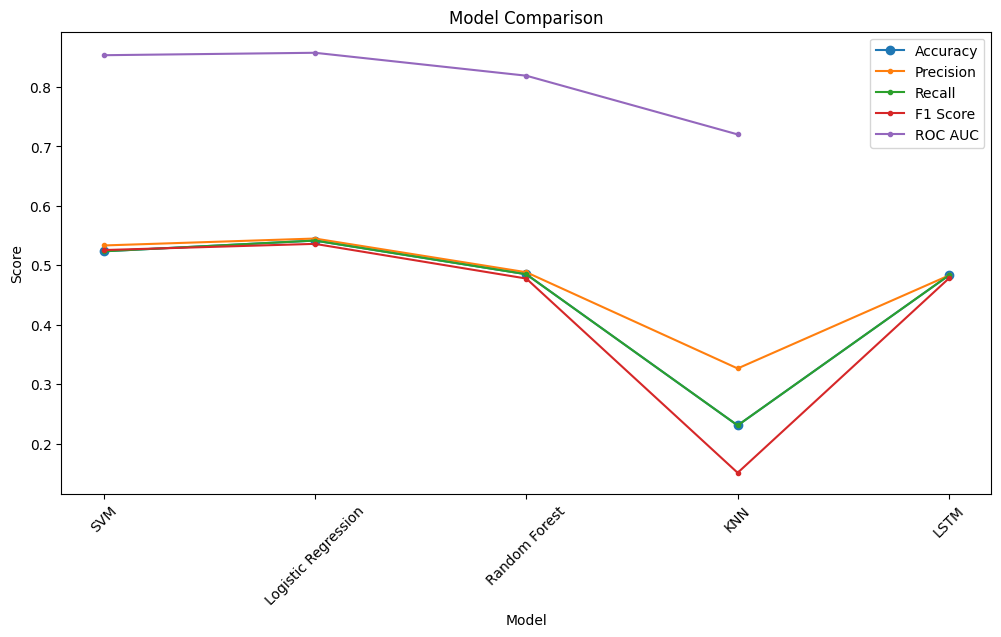

In [77]:
# Compare the performance of different models
models = ["SVM", "Logistic Regression", "Random Forest", "KNN", "LSTM"]
accuracies = [accuracy, accuracy_lr, accuracy_rf, accuracy_knn, accuracy_lstm]
precisions = [precision, precision_lr, precision_rf, precision_knn, precision_lstm]
recalls = [recall, recall_lr, recall_rf, recall_knn, recall_lstm]
f1_scores = [f1, f1_lr, f1_rf, f1_knn, f1_lstm]
roc_auc_scores = [
    roc_auc,
    roc_auc_lr,
    roc_auc_rf,
    roc_auc_knn,
    roc_auc_lstm,
]

model_comparison = pd.DataFrame(
    {
        "Model": models,
        "Accuracy": accuracies,
        "Precision": precisions,
        "Recall": recalls,
        "F1 Score": f1_scores,
        "Rou_AUC": roc_auc_scores,
    }
)

print(model_comparison)

# Plot the model comparison
plt.figure(figsize=(12, 6))
plt.plot(models, accuracies, marker="o", label="Accuracy")
plt.plot(models, precisions, marker=".", label="Precision")
plt.plot(models, recalls, marker=".", label="Recall")
plt.plot(models, f1_scores, marker=".", label="F1 Score")
plt.plot(models, roc_auc_scores, marker=".", label="ROC AUC")
plt.title("Model Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.xticks(rotation=45)
plt.show()